In [2]:
'!unzip "/kaggle/input/dogs-vs-cats/train.zip"'

'!unzip "/kaggle/input/dogs-vs-cats/train.zip"'

In [3]:
import pandas as pd
import torch
import os
import random
import torch.nn as nn
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import transforms

In [4]:
train_path = "/kaggle/working/train"
dirs = os.listdir(train_path)

random.shuffle(dirs)
train_paths = dirs[5000:] 
val_paths = dirs[:5000] 

In [5]:
class dataset(Dataset):
    def __init__(self, paths, transform = None) :
        self.paths = paths
        self.transform = transform
        
    
    def __getitem__(self, index):
        full_path = os.path.join(train_path, self.paths[index])
        img = Image.open(full_path)
        img = img.resize((224, 224))
        label = self.paths[index][:3]
        
        if self.transform:
            img = self.transform(img)
            img = img.type(torch.float32)/255 
            
        return img, int(label == "cat")
    
    def __len__(self):
        return len(self.paths)

In [6]:
transform = transforms.Compose([
    transforms.PILToTensor(),
])

In [7]:
train_data = dataset(train_paths, transform)
val_data = dataset(val_paths, transform)

In [8]:
train_loader = DataLoader(train_data, shuffle = True, batch_size = 32)
val_loader = DataLoader(val_data, shuffle = False, batch_size = 32)

In [9]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0, bias=True):
        super(ConvBlock, self).__init__()
        
        self.Conv_layer = nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride = stride, padding=padding, bias=bias)
        self.batchnorm2d = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        return self.relu(self.batchnorm2d(self.Conv_layer(x)))

In [10]:
class InceptionBlock(nn.Module):
    def __init__(self, in_channels, output_1x1, reduc_3x3, output_3x3, reduc_5x5, output5x5, out_1x1_mxpooling):
        super(InceptionBlock, self).__init__()
        
        self.branch1 = ConvBlock(in_channels, output_1x1, kernel_size=1)
        
        self.branch2 = nn.Sequential(ConvBlock(in_channels, reduc_3x3, kernel_size=1), ConvBlock(reduc_3x3, output_3x3, kernel_size=3, stride=1, padding=1))
        
        self.branch3 = nn.Sequential(ConvBlock(in_channels, reduc_5x5, kernel_size=1), ConvBlock(reduc_5x5, output5x5, kernel_size=5, stride=1, padding=2))
        
        self.branch4 = nn.Sequential(nn.MaxPool2d(kernel_size=3, stride=1, padding=1), ConvBlock(in_channels, out_1x1_mxpooling, kernel_size=1, stride=1))
        
    def forward(self, x):
        return torch.cat([self.branch1(x), self.branch2(x), self.branch3(x), self.branch4(x)], dim=1)

In [11]:
class Auxiliary(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(Auxiliary, self).__init__()
        
        self.avg = nn.AvgPool2d(kernel_size=5, stride=3)
        self.conv1 = ConvBlock(in_channels, 128, kernel_size=1)
        
        self.flatten = nn.Flatten()
        
        self.fc1 = nn.Linear(2048, 1024)
        self.fc2 = nn.Linear(1024, num_classes)
        
        self.dropout = nn.Dropout(.7)
        
    def forward(self, x):
        x = self.avg(x)
        x = self.conv1(x)
        
        x = self.flatten(x)
        
        x = nn.ReLU()(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        
        return x     

In [12]:
class Inception(nn.Module):
    def __init__(self, num_classes):
        super(Inception, self).__init__()
        
        self.conv1 = ConvBlock(3, 64, kernel_size=7, stride=2)
        self.conv2 = ConvBlock(64, 192, kernel_size=3, stride=1)
        
        self.inception3a = InceptionBlock(192, 64, 96, 128, 16, 32, 32)
        self.inception3b = InceptionBlock(256, 128, 128, 192, 32, 96, 64)
        self.inception4a = InceptionBlock(480, 192, 96, 208, 16, 48, 64)
        self.inception4b = InceptionBlock(512, 160, 112, 224, 24, 64, 64)
        self.inception4c = InceptionBlock(512, 128, 128, 256, 24, 64, 64)
        self.inception4d = InceptionBlock(512, 112, 144, 288, 32, 64, 64)
        self.inception4e = InceptionBlock(528, 256, 160, 320, 32, 128, 128)
        self.inception5a = InceptionBlock(832, 256, 160, 320, 32, 128, 128)
        self.inception5b = InceptionBlock(832, 384, 192, 384, 48, 128, 128)
        
        self.mx = nn.MaxPool2d(kernel_size=3, stride =2, padding=1)
        self.avg = nn.AvgPool2d(kernel_size=7, stride =1)
        
        self.dropout = nn.Dropout(.4)
        self.linear1 = nn.Linear(1024, 1000)
        self.linear2 = nn.Linear(1000, num_classes)
        
        self.aux_1 = Auxiliary(in_channels = 512, num_classes = num_classes)
        self.aux_2 = Auxiliary(in_channels = 528, num_classes = num_classes)

    def forward(self, x):
        
        x = self.conv1(x)
        x = self.mx(x)
        
        x = self.conv2(x)
        x = self.mx(x)        
        
        x = self.inception3a(x)
        x = self.inception3b(x)
        x = self.mx(x)
        x = self.inception4a(x)
        
        if self.training:
            aux1 = self.aux_1(x)
            
        x = self.inception4b(x)
        x = self.inception4c(x)
        x = self.inception4d(x)
        
        if self.training:
            aux2 = self.aux_2(x)
            
        x = self.inception4e(x)
        x = self.mx(x)
        x = self.inception5a(x)
        x = self.inception5b(x)
        x = self.avg(x)
        
        x = nn.Flatten()(x)
        x = self.dropout(x)
        x = nn.ReLU()(self.linear1(x))
        
        x = self.linear2(x)
        
        if self.training:
            return x ,aux1, aux2
        else:
            return x

In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [14]:
model = Inception(2).to(device)

epochs = 10
lr = .005
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [15]:
train_loss_history = []
val_loss_history = []
best_score = float("inf")
tol = 0


def train_epoch():
    epoch_loss = 0
    for i, (images, labels) in enumerate(train_loader):
        
        images = images.to(device)
        labels = labels.to(device)
        
        # forward pass
        out, aux1, aux2 = model(images)
        
        loss_out = criterion(out, labels)
        aux1_loss = criterion(aux1, labels)
        aux2_loss = criterion(aux2, labels)
        loss = loss_out + .3*(aux1_loss + aux2_loss)
        epoch_loss += loss
        
        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if(i%100 ==0):
            print(f"   step[{i+1} / {len(train_loader)}]")
    return epoch_loss / len(train_loader)

def get_val_loss():
    epoch_loss = 0
    with torch.no_grad():
        for i, (images, labels) in enumerate(val_loader):

            images = images.to(device)
            labels = labels.to(device)

            # forward pass
            out = model(images)
            loss = criterion(out, labels)
            epoch_loss += loss
            
    return epoch_loss / len(val_loader)

for epoch in range(epochs):
    print(f"epoch {epoch+1}:")
    
    model.train(True)
    avg_train_epoch_loss = train_epoch()
    
    model.eval()
    avg_val_epoch_loss = get_val_loss()
    
    if(avg_val_epoch_loss < best_score):
        best_score = avg_val_epoch_loss
        torch.save(model.state_dict(), f"model_{epoch+1}")
    else:
        tol += 1
        if(tol == 4):
            break
    
    
    train_loss_history.append(avg_train_epoch_loss)
    val_loss_history.append(avg_val_epoch_loss)
    
    
    print(f"epoch: {epoch+1} --- avg_train_loss = {avg_train_epoch_loss} --- avg_val_loss = {avg_val_epoch_loss}") 
    print("#"*100)

epoch 1:
   step[1 / 625]
   step[101 / 625]
   step[201 / 625]
   step[301 / 625]
   step[401 / 625]
   step[501 / 625]
   step[601 / 625]
epoch: 1 --- avg_train_loss = 1.1638718843460083 --- avg_val_loss = 0.6972315311431885
####################################################################################################
epoch 2:
   step[1 / 625]
   step[101 / 625]
   step[201 / 625]
   step[301 / 625]
   step[401 / 625]
   step[501 / 625]
   step[601 / 625]
epoch: 2 --- avg_train_loss = 0.8985034227371216 --- avg_val_loss = 0.6894651651382446
####################################################################################################
epoch 3:
   step[1 / 625]
   step[101 / 625]
   step[201 / 625]
   step[301 / 625]
   step[401 / 625]
   step[501 / 625]
   step[601 / 625]
epoch: 3 --- avg_train_loss = 0.6393473744392395 --- avg_val_loss = 0.601358950138092
####################################################################################################
epoch 4:
   step[

In [16]:
train_losses = [ x.item() for x in train_loss_history]
val_losses = [ x.item() for x in val_loss_history]

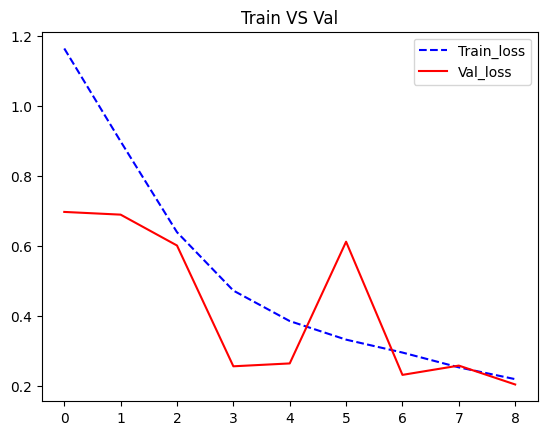

In [17]:
import matplotlib.pyplot as plt

plt.plot(train_losses, "b--", label = "Train_loss")
plt.plot(val_losses, "r-", label = "Val_loss")
plt.title("Train VS Val")
plt.legend()
plt.show()